In [3]:
import numpy as np
import pandas as pd
from CFA_function import ClusteredFactorAnalysis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance_nd
import sys
sys.path.insert(0, './utils')
from visualization import Plotter
from evaluation import Evaluation
from factor_analysis import FactorModel
from statistical_tools import multivariate_likelihood

In [5]:
# Generate spatial information
def generate_blobs(n_samples=100, n_features=2, centers=None, cluster_std=0.2, center_box=(-1.0, 1.0), shuffle=True, random_state=None, return_centers=False):
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate centers if not provided
    if centers is None:
        centers = 4
    if isinstance(centers, int):
        centers = np.random.uniform(center_box[0]+0.3, center_box[1]-0.3, size=(centers, n_features))

    centers = np.array(centers)
    n_centers = centers.shape[0]

   # Handle cluster standard deviations
    cluster_std = np.full(n_centers, cluster_std) if isinstance(cluster_std, (int, float)) else np.array(cluster_std)

    # Handle sample size per center
    if isinstance(n_samples, int):
        n_samples_per_center = np.full(n_centers, n_samples // n_centers, dtype=int)
        n_samples_per_center[:n_samples % n_centers] += 1
    else:
        n_samples_per_center = n_samples

    X, y = [], []
    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        samples = np.random.normal(loc=centers[i], scale=std, size=(n, n_features))
        X.append(samples)
        y.extend([i] * n)

    X = np.vstack(X)
    y = np.array(y)

    if shuffle:
        indices = np.random.permutation(len(X))
        X, y = X[indices], y[indices]

    return X, y

def data_location(n_samples,n_groups,random_state,type):
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    if type == 'blobs':
        return generate_blobs(n_samples=n_samples, n_features=2, centers=n_groups, center_box=(-1, 1), random_state=random_state, return_centers=False)
    
    elif type == 'aniso':
        X, y = generate_blobs(n_samples=n_samples, n_features=2, centers=[[0.5, 0.5],[-0.5, 0.5],  [-0.5, -0.5], [0.5, -0.5]], center_box=(-1, 1), random_state=random_state, return_centers=False)
        X = np.dot(X, transformation)
        return X, y
    
    elif type == 'varied':
        return generate_blobs(n_samples=n_samples, n_features=2, centers=n_groups, center_box = (-1,1), cluster_std=[0.2, 0.15, 0.3,  0.06], random_state=random_state)
    
    elif type == 'unevenly':
        # generate group sizes for each group
        group_sizes = [ n_samples - (n_samples // 2 + n_samples // 5 + n_samples // 20),n_samples // 5, n_samples // 2, n_samples // 20]
        
        # generate more samples to ensure we have enough samples for each group
        X, y = generate_blobs(n_samples=2 *n_samples, n_features=2, centers=n_groups, center_box = (-1,1), random_state=random_state)
        
        X_filtered, y_filtered = [], []

        for i, size in enumerate(group_sizes):
            indices = np.where(y == i)[0][:size]
            X_filtered.append(X[indices])
            y_filtered.extend([i] * len(indices))

        return np.vstack(X_filtered), np.array(y_filtered)
    
    elif type == 'uniform':
        X_scaled = np.random.uniform(-1, 1, (n_samples, 2))

        # group definition
        y = np.zeros(n_samples, dtype=int)
        y[(X_scaled[:, 0] > 0) & (X_scaled[:, 1] > 0)] = 0  # D1
        y[(X_scaled[:, 0] < 0) & (X_scaled[:, 1] > 0)] = 1  # D2
        y[(X_scaled[:, 0] < 0) & (X_scaled[:, 1] < 0)] = 2  # D3
        y[(X_scaled[:, 0] > 0) & (X_scaled[:, 1] < 0)] = 3  # D4

        return X_scaled, y
    elif type == 'radial':
        X = np.random.uniform(-1, 1, (n_samples, 2))
        distances = np.linalg.norm(X, axis=1)
        r1, r2, r3 = 0.25, 0.5, 0.75
        y = np.digitize(distances, [r1, r2, r3])
        return X,y

In [9]:
#Generate simulation data for Factor Analysis

def simulation_data_generator(n,p,m,sigma2,tau2,mu,type_,group_size=4):
    '''
    Generate simulation data for Clustered Factor Analysis
    :param n: number of samples
    :param p: dimension of observed vector
    :param m: number of factors
    :param sigma2: variance of error term
    :param tau2: variance of factor loading
    :param mu: mean of factor loading

    :return: x, A, f, epsilon
    '''
    
    # np.random.seed(42)  # Ensure reproducibility

    #location information
    s,groups=data_location(n,group_size,None,type_)

    # Initialize variables
    x = np.zeros((n, p))
    f = np.random.normal(0, 1, (n, m))
    epsilon = np.random.normal(0, sigma2, (n, 1))
    A = np.zeros((group_size, p, m))

    # Generate loadings matrix A and data
    num_iterations = 1000  # Number of iterations for sampling
    for g in range(group_size):
        for k in range(m):
            # mutiple sampling to get a better estimate of the mean and variance
            sample_means = []
            sample_vars = []

            for _ in range(num_iterations):
                generated_data = np.random.normal(mu[g, k], tau2, p)
                sample_means.append(np.mean(generated_data))
                sample_vars.append(np.var(generated_data))
            mean_of_means = np.mean(sample_means)
            mean_of_vars = np.mean(sample_vars)
            generated_data = np.random.normal(mean_of_means, np.sqrt(mean_of_vars), p)
            A [g, :, k] = (generated_data - np.mean(generated_data)) / np.std(generated_data) * tau2 + mu[g, k]   
        indices = np.where(groups == g)[0]
        x[indices] = np.dot(A[g], f[indices].T).T

    # Add noise to the data
    x = x + epsilon
    

    return x, f, s, epsilon, A, groups

mu = np.array([
    [1, 1, 1],
    [-1, 0.5, 0.5],
    [0.5, -1, 0.5],
    [0.5, 0.5, -1]
])

In [23]:
#evaluation metrics for model performance
def calculate_difference(x, y, name):
    if name =='frobenius':
        return np.linalg.norm(x - y, 'fro')
    elif name == 'max abs':
        return np.max(np.abs(x - y))
    elif name == 'wasserstein':
        return wasserstein_distance_nd(x, y)
    else:
        raise ValueError('Unknown distance metric')

In [18]:
dfs=[]
factor_number=3
cluster_type='blobs'
group_size= 4
grouptype=['random','kmeans']
sp_mode=['top5','euclidean']
for i in range(50):
    data_200, factor, s, e, A, groups = simulation_data_generator(200, 10, factor_number, 0.3, 1, mu, type_=cluster_type, group_size=group_size)
    sample_A = A[groups]
    sample_AAT = np.array([np.dot(A[idx], A[idx].T) for idx in groups])
    df=pd.DataFrame(columns=['cluster type','model','mode','frobenius','chebyshv','wasserstein','AIC'])

    #EFA
    cov_,Load_Matrix,_,_,_,_=FactorModel(data_200).fit_fa(factor_number)
    standard_AAT = np.tile(np.dot(Load_Matrix,Load_Matrix.T), (200, 1, 1))
    max_loglike=[]
    labels = []    
    X = data_200
    mean_vector = np.zeros(X.shape[1])        
    loglike=[]
    for i in range(len(X)):
        loglike.append(multivariate_likelihood(X[i], mean_vector, cov_))
    num_feature = data_200.shape[1]
    
    num_params = num_feature  * factor_number + num_feature 
    standard_aic = (2 * num_params - 2 * sum(loglike))


    s_frobenius = np.mean([calculate_difference(sample_AAT[i], standard_AAT[i], 'frobenius') for i in range(200)]).round(3)
    s_chebyshv = np.mean([calculate_difference(sample_AAT[i], standard_AAT[i], 'max abs') for i in range(200)]).round(3)
    s_wasserstein = np.mean([calculate_difference(sample_AAT[i], standard_AAT[i], 'wasserstein') for i in range(200)]).round(3)

    # Create a new DataFrame with a single row of data
    new_row = pd.DataFrame({
        'cluster type':[cluster_type],
        'model': ['EFA'],
        'mode': ['--'],
        'frobenius': [s_frobenius],
        'chebyshv': [s_chebyshv],
        'wasserstein': [s_wasserstein],
        'AIC': [standard_aic]
    })

    # Concatenate the new row to the existing DataFrame
    df = pd.concat([df, new_row], ignore_index=True)

    #SCFA
    for gt in grouptype:
        for sp in sp_mode:
            cfa= ClusteredFactorAnalysis(pd.DataFrame(data_200),s, group_size = group_size, factor_number = factor_number, group_type = gt, maxitr = 50, sp_mode = sp, phi=1)
            re=cfa.fit()    

            estimasted_A=np.array([re.Load_Matrix_dict[idx] for idx in re.groups_indexs])
            estimasted_AAT=np.array([np.dot(re.Load_Matrix_dict[idx], re.Load_Matrix_dict[idx].T) for idx in re.groups_indexs])    

            _frobenius = np.mean([calculate_difference(sample_AAT[i], estimasted_AAT[i], 'frobenius') for i in range(200)]).round(3)
            _chebyshv = np.mean([calculate_difference(sample_AAT[i], estimasted_AAT[i], 'max abs') for i in range(200)]).round(3)
            _wasserstein = np.mean([calculate_difference(sample_AAT[i], estimasted_AAT[i], 'wasserstein') for i in range(200)]).round(3)

            eva=Evaluation(data_200,re)
            CFA_aic=eva.calculate_AIC()    
            new_row =  pd.DataFrame({
                'cluster type':[cluster_type],
                'model': ['SCFA'],
                'mode': [gt+'_'+sp],
                'frobenius': [_frobenius],
                'chebyshv': [_chebyshv],
                'wasserstein': [_wasserstein],
                'AIC': [CFA_aic]
            })
            df = pd.concat([df, new_row], ignore_index=True)
    
    dfs.append(df)

# merge the DataFrames along a new axis
concatenated = pd.concat(dfs)
mean_df = concatenated.groupby(['cluster type','model', 'mode'], as_index=False).mean()
mean_df=mean_df.applymap(lambda x: round(x,4) if isinstance(x, (int, float)) else x)
mean_df['AIC']=mean_df['AIC'].astype(int)

In [19]:
mean_df

,cluster type,model,mode,frobenius,chebyshv,wasserstein,AIC
0,blobs,EFA,--,30.3819,10.8827,8.6577,8294
1,blobs,SCFA,kmeans_euclidean,28.9370,10.6848,8.1557,4184
2,blobs,SCFA,kmeans_top5,29.3098,10.7294,8.2840,4363
3,blobs,SCFA,random_euclidean,29.3261,10.7414,8.2929,4518
4,blobs,SCFA,random_top5,29.5396,10.7677,8.3667,4572


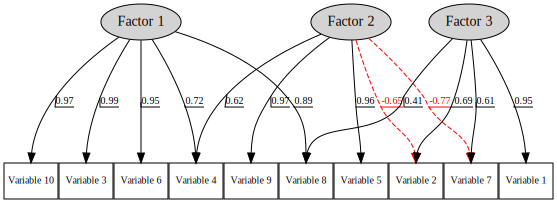

In [20]:
Plotter(data_200,re,s).plot_diagram(3)

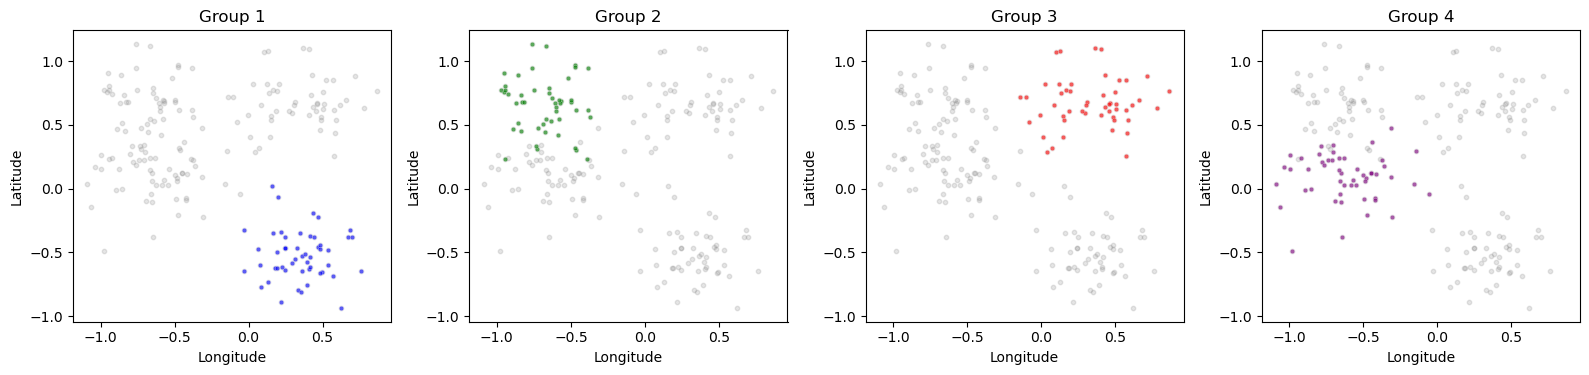

In [22]:
Plotter(data_200,re,s).each_group_location('')